### 使用pytorch获得Voc2012数据集

pytorch TORCHVISION.DATASETS.VOC自带有多种数据集的下载

In [2]:
import os
import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms # pytorch计算机视觉库，含多种数据集
import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import cv2 # opencv

data_path = os.path.dirname(os.getcwd())+"/data"
# 训练集
train_dataset = datasets.VOCSegmentation(root=data_path,year='2012',image_set='train',transform=transforms.ToTensor(),download=False)
# 训练集的验证集
test_dataset = datasets.VOCSegmentation(root=data_path,year='2012',image_set='trainval',transform=transforms.ToTensor(),download=False)



Using downloaded and verified file: /Users/alexleung/PycharmProjects/DeepLearning-Practice/data/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /Users/alexleung/PycharmProjects/DeepLearning-Practice/data/VOCtrainval_11-May-2012.tar


# VGG16 
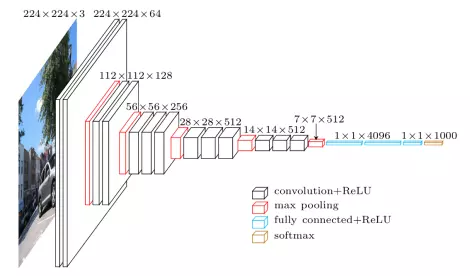

- INPUT: [224x224x3]        memory:  224*224*3=150K   weights: 0
- CONV3-64: [224x224x64]  memory:  224*224*64=3.2M   weights: (3*3*3)*64 = 1,728
- CONV3-64: [224x224x64]  memory:  224*224*64=3.2M   weights: (3*3*64)*64 = 36,864
- POOL2: [112x112x64]  memory:  112*112*64=800K   weights: 0
- CONV3-128: [112x112x128]  memory:  112*112*128=1.6M   weights: (3*3*64)*128 = 73,728
- CONV3-128: [112x112x128]  memory:  112*112*128=1.6M   weights: (3*3*128)*128 = 147,456
- POOL2: [56x56x128]  memory:  56*56*128=400K   weights: 0
- CONV3-256: [56x56x256]  memory:  56*56*256=800K   weights: (3*3*128)*256 = 294,912
- CONV3-256: [56x56x256]  memory:  56*56*256=800K   weights: (3*3*256)*256 = 589,824
- CONV3-256: [56x56x256]  memory:  56*56*256=800K   weights: (3*3*256)*256 = 589,824
- POOL2: [28x28x256]  memory:  28*28*256=200K   weights: 0
- CONV3-512: [28x28x512]  memory:  28*28*512=400K   weights: (3*3*256)*512 = 1,179,648
- CONV3-512: [28x28x512]  memory:  28*28*512=400K   weights: (3*3*512)*512 = 2,359,296
- CONV3-512: [28x28x512]  memory:  28*28*512=400K   weights: (3*3*512)*512 = 2,359,296
- POOL2: [14x14x512]  memory:  14*14*512=100K   weights: 0
- CONV3-512: [14x14x512]  memory:  14*14*512=100K   weights: (3*3*512)*512 = 2,359,296
- CONV3-512: [14x14x512]  memory:  14*14*512=100K   weights: (3*3*512)*512 = 2,359,296
- CONV3-512: [14x14x512]  memory:  14*14*512=100K   weights: (3*3*512)*512 = 2,359,296
- POOL2: [7x7x512]  memory:  7*7*512=25K  weights: 0
- FC: [1x1x4096]  memory:  4096  weights: 7*7*512*4096 = 102,760,448
- FC: [1x1x4096]  memory:  4096  weights: 4096*4096 = 16,777,216
- FC: [1x1x1000]  memory:  1000 weights: 4096*1000 = 4,096,000

### Network Architecture
### 输入
- 224x224x3 三通道图片
### conv1_1
- 224x224x64 为什么和原图片大小？尺寸是3x3的卷积核假设步长为1，输出尺寸为222x222，但是在此做了1圈的填充，所以尺寸变回(222+2)x(222+2)


In [3]:
'''VGG16 model for Keras.
# Reference:
- [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)
# Code adopted from:
# https://github.com/fchollet/deep-learning-models/blob/master/vgg16.py
'''
from __future__ import print_function

import numpy as np
import warnings

from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs


WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'


def VGG16(include_top=True, weights='imagenet',
          input_tensor=None, input_shape=None,
          pooling=None,
          classes=1000):
    """Instantiates the VGG16 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 244)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      include_top=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg16')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model


if __name__ == '__main__':
    model = VGG16(include_top=True, weights='imagenet')

    img_path = 'elephant.jpg'
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    print('Input image shape:', x.shape)

    preds = model.predict(x)
    print('Predicted:', decode_predictions(preds))
        
        
        
        